# Annual income prediction (binary classification)
### Author: Dominik Kurowski
***

### Table of Contents:
#### 1. [Exploratory data analysis (EDA)](#title1)
#### 2. [Data cleaning](#title2)
#### 3. [Building classification models](#title3)
#### 4. [Classification models comparison](#title4)

<br>
In this notebook I will guide you through the subsequent stages of the dataset analysis and creation of chosen classification models (Random Forest, KNN, Decision Tree and Naive Gaussian) with their futher comparison. I will try to answer the question of whether given person annual income is above or below given threshold (in this example 50k USD), based on this person characteristics.

<br><br>
**Dataset source:** https://www.kaggle.com/mastmustu/income

## Importing libraries
***

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score

<a id='title1'></a>
## Exloratory Data Analysis (EDA)
***
### 1. Loading the dataset

In [2]:
data = pd.read_csv('./data/people.csv').drop(['fnlwgt', 'capital-gain', 'capital-loss'], axis=1)


### 2. Understanding structure of our dataset

In [3]:
data

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income_>50K
0,67,Private,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,60,United-States,1
1,17,Private,12th,8,Never-married,Other-service,Own-child,White,Male,15,United-States,0
2,31,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,40,United-States,1
3,58,State-gov,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,40,United-States,0
4,25,State-gov,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43952,52,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,United-States,1
43953,19,Private,HS-grad,9,Never-married,Other-service,Own-child,White,Female,40,United-States,0
43954,30,Private,Some-college,10,Divorced,Sales,Not-in-family,White,Male,58,United-States,0
43955,46,Private,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,35,United-States,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              43957 non-null  int64 
 1   workclass        41459 non-null  object
 2   education        43957 non-null  object
 3   educational-num  43957 non-null  int64 
 4   marital-status   43957 non-null  object
 5   occupation       41451 non-null  object
 6   relationship     43957 non-null  object
 7   race             43957 non-null  object
 8   gender           43957 non-null  object
 9   hours-per-week   43957 non-null  int64 
 10  native-country   43194 non-null  object
 11  income_>50K      43957 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 4.0+ MB


In [5]:
data.isnull().sum()

age                   0
workclass          2498
education             0
educational-num       0
marital-status        0
occupation         2506
relationship          0
race                  0
gender                0
hours-per-week        0
native-country      763
income_>50K           0
dtype: int64

There are some *null* values in our dataset, we will take care of them later.

### 3. Data feature analysis
#### + Breakdown of income

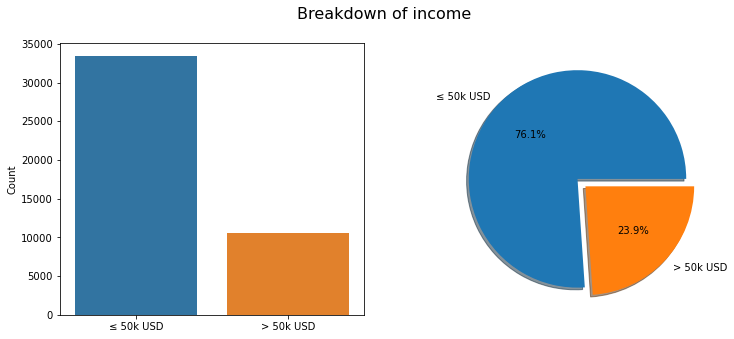

In [6]:
values = data['income_>50K'].value_counts()
labels = ['≤ 50k USD', '> 50k USD']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

fig.suptitle('Breakdown of income', fontsize=16)
sns.countplot(x='income_>50K', data=data, ax=axs[0])
axs[0].set(xlabel="", ylabel = "Count", xticklabels=labels)
axs[1].pie(values, labels=labels, 
    autopct='%1.1f%%', shadow=True, explode=[0,0.1])
plt.show()

As we can see, only **23.9%** of our chosen sample (10518 people) reach annual income of more than 50k USD. <br><br>
Further in the notebook we will try to analyze wich features have the greatest impact on high income. Based on that, we will try to create model that accurately predicts whatever given person earns more than 50k USD a year.

#### + Relation between earnings and gender

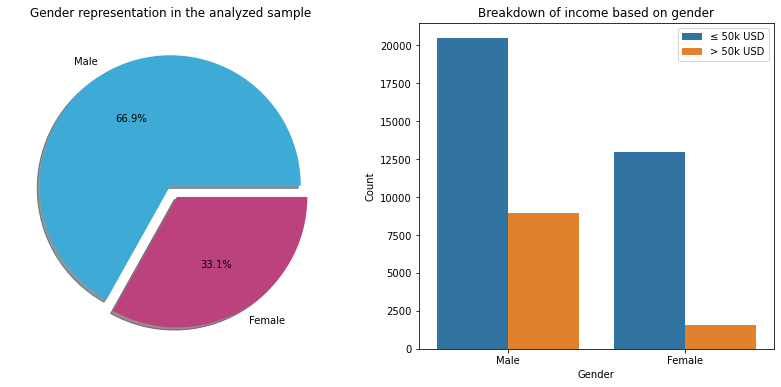

In [7]:
values = data['gender'].value_counts()
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].pie(values, labels=['Male', 'Female'], colors=['#3DABD5', '#BB427D'],
    autopct='%1.1f%%', shadow=True, explode=[0, 0.1])
axs[0].set_title('Gender representation in the analyzed sample')

sns.countplot(x='gender', hue='income_>50K', data=data, ax=axs[1])
axs[1].set(title='Breakdown of income based on gender', xlabel='Gender', ylabel = 'Count')
axs[1].legend(labels)
plt.show()

In [8]:
pd.crosstab(data['income_>50K'], data['gender'], rownames=['Income > 50k USD'], margins=True)

gender,Female,Male,All
Income > 50k USD,,,
0,12967,20472,33439
1,1590,8928,10518
All,14557,29400,43957


#### + Relation between earnings and age

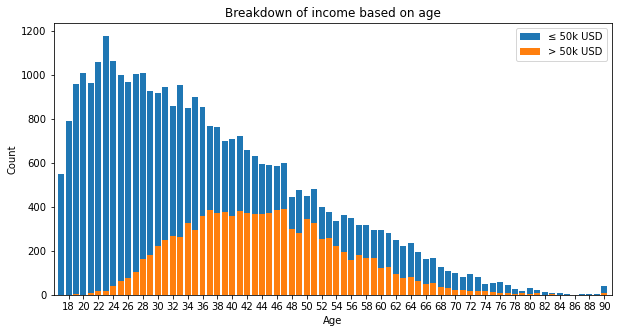

In [9]:
min_age = data['age'].min()
max_age = data['age'].max()
labels = np.arange(min_age, max_age+1)

below = data[['age', 'income_>50K']][data['income_>50K'] == 0].groupby('age').count().squeeze()
above = data[['age', 'income_>50K']][data['income_>50K'] == 1].groupby('age').count().squeeze()

# Fill missing keys
missing_keys = below.keys().difference(above.keys())
missing_keys = missing_keys.to_series()
missing_keys[:] = 0
above = above.add(missing_keys, fill_value=0)

fig, axs = plt.subplots(figsize=(10, 5))
axs.bar(labels, below, label='≤ 50k USD')
axs.bar(labels, above, label='> 50k USD')
axs.set(title='Breakdown of income based on age', xlabel='Age', ylabel='Count')
axs.set(xlim=(16,91), xticks=np.arange(18,92,2))
axs.legend(loc='upper right')

plt.show()

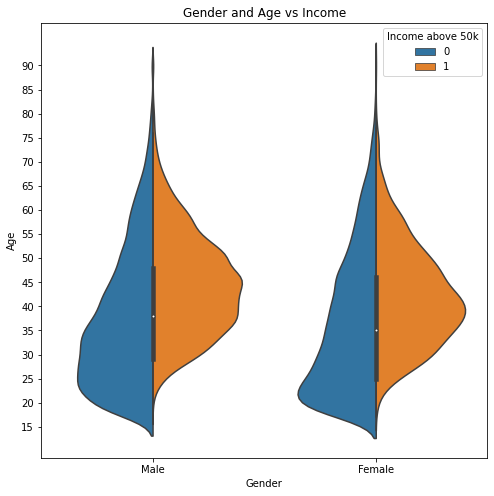

In [10]:
fig, axs = plt.subplots(figsize=(8, 8))

sns.violinplot(x="gender", y="age", hue='income_>50K', data=data, split=True, ax=axs)
axs.set(title='Gender and Age vs Income', xlabel='Gender', ylabel='Age')
axs.set_yticks(range(15,95,5))
axs.legend(title="Income above 50k")

plt.show()

#### + Relation between earnings and education

In [11]:
# Prepare sorted keys values for plot
arg_sort = data['educational-num'].unique().argsort()
keys_pre_hs = data['education'].unique()[arg_sort][:8]
keys_post_hs = data['education'].unique()[arg_sort][8:]
print('Pre highschool: ', keys_pre_hs)
print('post highschool: ', keys_post_hs)

Pre highschool:  ['Preschool' '1st-4th' '5th-6th' '7th-8th' '9th' '10th' '11th' '12th']
post highschool:  ['HS-grad' 'Some-college' 'Assoc-voc' 'Assoc-acdm' 'Bachelors' 'Masters'
 'Prof-school' 'Doctorate']


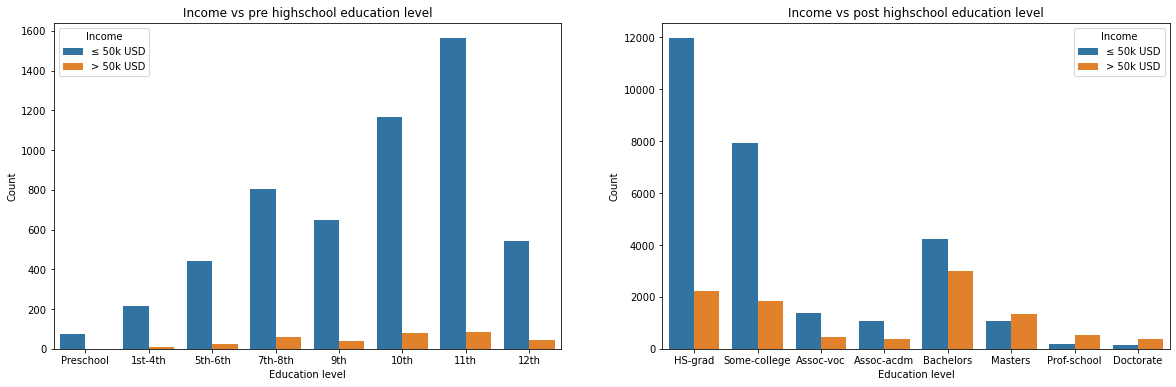

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.countplot(x='education', hue='income_>50K', order=keys_pre_hs, 
    data=data[data['education'].isin(keys_pre_hs)], ax=axs[0])
axs[0].set(title='Income vs pre highschool education level', xlabel='Education level', ylabel = 'Count')
axs[0].legend(title="Income", labels=['≤ 50k USD', '> 50k USD'])

sns.countplot(x='education', hue='income_>50K', order=keys_post_hs, 
    data=data[data['education'].isin(keys_post_hs)], ax=axs[1])
axs[1].set(title='Income vs post highschool education level', xlabel='Education level', ylabel = 'Count')
axs[1].legend(title="Income", labels=['≤ 50k USD', '> 50k USD'])
plt.show()

In [13]:
crosstab = pd.crosstab(data['income_>50K'], data['educational-num'],
    rownames=['Income > 50k USD'], colnames=['Education level'], margins=True)

arg_sort = data['educational-num'].unique().argsort()
keys = data['education'].unique()[arg_sort]
new_columns = {old : new for old, new in zip(crosstab.columns, keys)}
crosstab.rename(columns=new_columns, inplace=True)
crosstab

Education level,Preschool,1st-4th,5th-6th,7th-8th,9th,10th,11th,12th,HS-grad,Some-college,Assoc-voc,Assoc-acdm,Bachelors,Masters,Prof-school,Doctorate,All
Income > 50k USD,,,,,,,,,,,,,,,,,
0,75,216,442,805,647,1168,1563,543,11973,7940,1362,1062,4230,1064,197,152,33439
1,1,7,26,57,37,82,84,44,2224,1850,469,385,2989,1328,551,384,10518
All,76,223,468,862,684,1250,1647,587,14197,9790,1831,1447,7219,2392,748,536,43957


** + Relation between earnings and relationship**

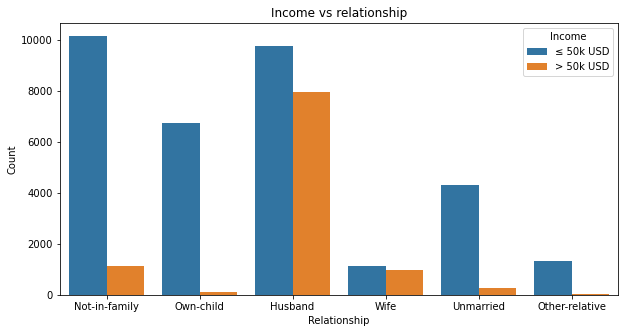

In [14]:
fig, axs = plt.subplots(figsize=(10, 5))

sns.countplot(x='relationship', hue='income_>50K', data=data, ax=axs)
axs.set(title='Income vs relationship', xlabel='Relationship', ylabel = 'Count')
axs.legend(title="Income", labels=['≤ 50k USD', '> 50k USD'])

plt.show()

<a id='title2'></a>
## Data cleaning
***

#### **+ Filling null values**

In [15]:
data.isnull().sum()

age                   0
workclass          2498
education             0
educational-num       0
marital-status        0
occupation         2506
relationship          0
race                  0
gender                0
hours-per-week        0
native-country      763
income_>50K           0
dtype: int64

In [16]:
# Show columns with NaN values
columns_with_null_values = data.columns[data.isna().any()].to_list()
print(columns_with_null_values)

['workclass', 'occupation', 'native-country']


In [17]:
# Fill all NaN values
for column in columns_with_null_values:
    data[column] = data[column].fillna('Not-specified')

data.isnull().sum()

age                0
workclass          0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
hours-per-week     0
native-country     0
income_>50K        0
dtype: int64

#### **+ Encode categorical values**

In [18]:
# Show all columns with object type values
columns_with_object_type = data.columns[data.dtypes == 'object']
print(columns_with_object_type)

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object')


In [19]:
# Change object type values to category type values
for column in columns_with_object_type:
    data[column] = data[column].astype('category')

In [20]:
data.dtypes

age                   int64
workclass          category
education          category
educational-num       int64
marital-status     category
occupation         category
relationship       category
race               category
gender             category
hours-per-week        int64
native-country     category
income_>50K           int64
dtype: object

In [21]:
# Encode categorical values
for column in columns_with_object_type:
    data[column] = data[column].cat.codes

#### **+ Remove redundant columns**

In [22]:
data.drop('educational-num', axis=1)

,age,workclass,education,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income_>50K
0,67,4,10,0,3,1,4,1,60,39,1
1,17,4,2,4,8,3,4,1,15,39,0
2,31,4,9,2,3,0,4,1,40,39,1
3,58,7,5,2,14,0,4,1,40,39,0
4,25,7,15,4,8,1,2,1,40,39,0
...,...,...,...,...,...,...,...,...,...,...,...
43952,52,4,9,2,3,0,4,1,50,39,1
43953,19,4,11,4,8,3,4,0,40,39,0
43954,30,4,15,0,12,1,4,1,58,39,0
43955,46,4,9,4,12,1,4,0,35,39,0


<a id='title3'></a>
## Building classification models
***

#### **+ Show correlation between columns**

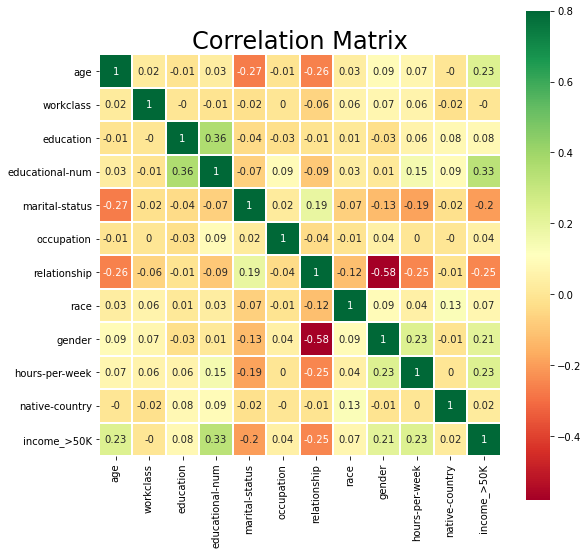

In [23]:
plt.figure(figsize=(9, 9))

plt.title('Correlation Matrix',fontsize=24)
sns.heatmap(data.corr().round(2), linewidths=0.1, vmax=0.8, square=True, cmap="RdYlGn",
    linecolor='w', annot=True)
plt.show()

#### **+ Split data between training and test sets**

In [24]:
x = data.drop('income_>50K', axis=1)
y = data['income_>50K']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#### **+ Random Forest classification model**

In [25]:
rfc_model = RandomForestClassifier()
rfc_model.fit(x_train, y_train)
y_pred = rfc_model.predict(x_test)

print("Random Forest classification model accuracy: %.3f" % accuracy_score(y_test, y_pred))

Random Forest classification model accuracy: 0.820


#### **+ KNN classification model**

In [26]:
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)

print("KNN classification model accuracy: %.3f" % accuracy_score(y_test, y_pred))

KNN classification model accuracy: 0.801


#### **+ Naive Bayes classification model**

In [27]:
nbc_model = GaussianNB()
nbc_model.fit(x_train, y_train)
y_pred = nbc_model.predict(x_test)

print("Naive Bayes classification model accuracy: %.3f" % accuracy_score(y_test, y_pred))

Naive Bayes classification model accuracy: 0.775


#### **+ Decision Tree classification model**

In [28]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(x_train, y_train)
y_pred = dtc_model.predict(x_test)

print("Decision Tree classification model accuracy: %.3f" % accuracy_score(y_test, y_pred))

Decision Tree classification model accuracy: 0.778


<a id='title4'></a>
## Classification models comparison
***

#### **+ Models accuracies**

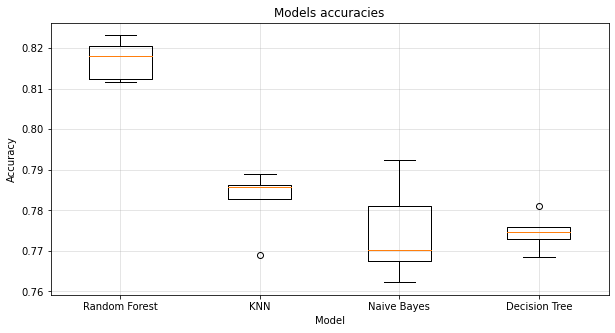

In [29]:
accuracy = []
models = [rfc_model, knn_model, nbc_model, dtc_model]

for model in models:
    cv = cross_val_score(model, x_test, y_test, scoring = "accuracy")
    cv = cv
    accuracy.append(cv)

accuracy_df = pd.DataFrame(accuracy, index=['Random Forest', 'KNN', 'Naive Bayes', 'Decision Tree']).T

fig, axs = plt.subplots(figsize=(10,5))
axs.boxplot(accuracy_df)
axs.set(title='Models accuracies', xlabel='Model', ylabel='Accuracy')
axs.set(xticklabels=['Random Forest', 'KNN', 'Naive Bayes', 'Decision Tree'])
axs.grid(which='major', alpha=0.4)
plt.show()

#### **+ Confusion Matrices**

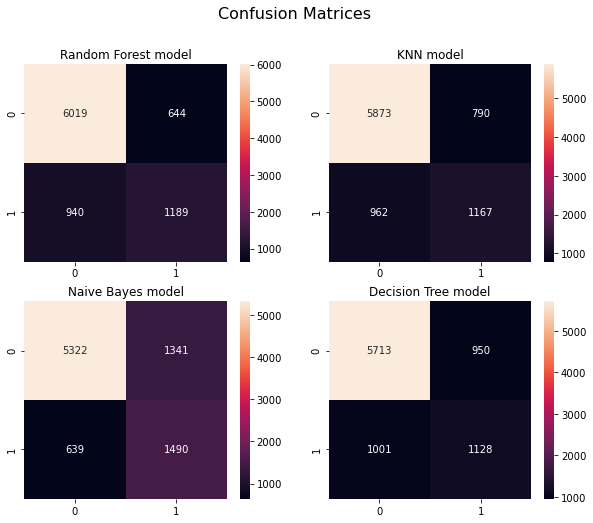

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

y_pred = rfc_model.predict(x_test)
sns.heatmap(confusion_matrix(y_test, y_pred), ax=axs[0,0], annot=True, fmt='2.0f')
axs[0,0].set_title('Random Forest model')

y_pred = knn_model.predict(x_test)
sns.heatmap(confusion_matrix(y_test, y_pred), ax=axs[0,1], annot=True, fmt='2.0f')
axs[0,1].set_title('KNN model')

y_pred = nbc_model.predict(x_test)
sns.heatmap(confusion_matrix(y_test, y_pred), ax=axs[1,0], annot=True, fmt='2.0f')
axs[1,0].set_title('Naive Bayes model')

y_pred = dtc_model.predict(x_test)
sns.heatmap(confusion_matrix(y_test, y_pred), ax=axs[1,1], annot=True, fmt='2.0f')
axs[1,1].set_title('Decision Tree model')

fig.suptitle('Confusion Matrices', fontsize=16)

plt.show()

#### **+ Feature Importance**

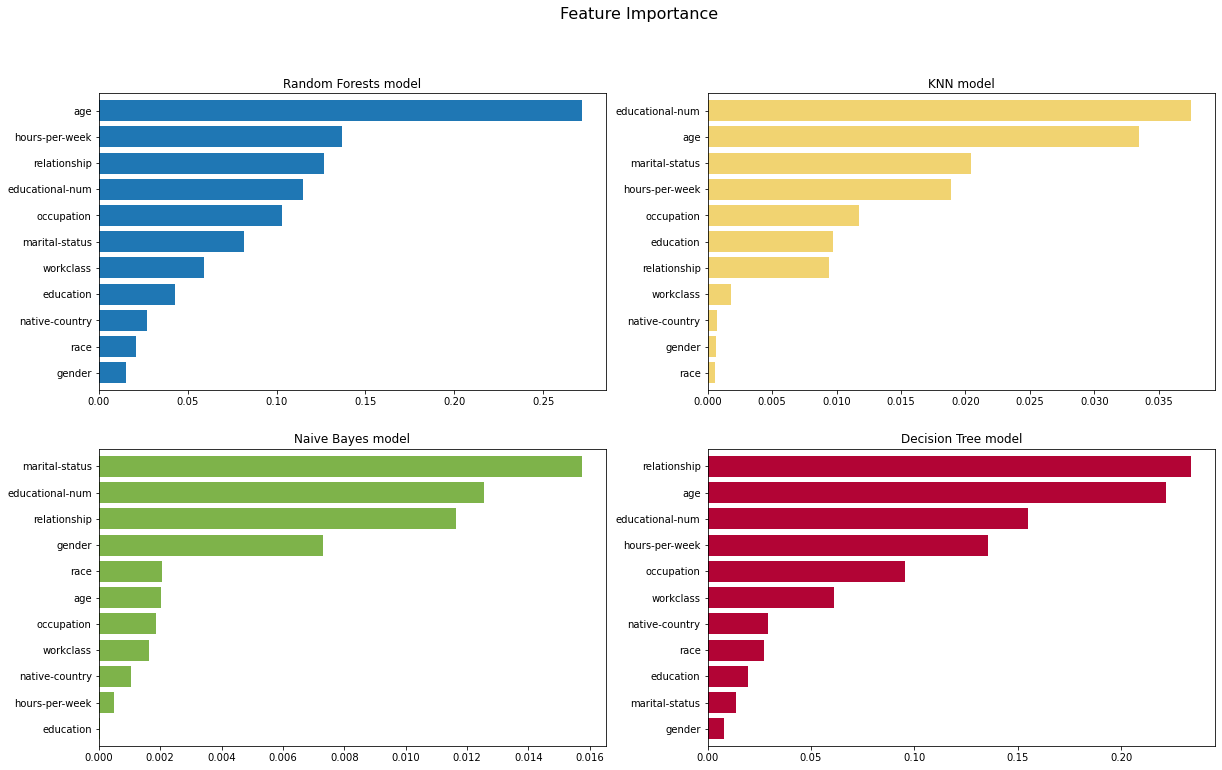

In [31]:
fig ,axs = plt.subplots(2, 2, figsize=(20,12))

pd.Series(rfc_model.feature_importances_, x_train.columns).sort_values(ascending=True).plot.barh(width=0.8, ax=axs[0,0])
axs[0,0].set_title('Random Forests model')

imps = permutation_importance(knn_model, x_test, y_test)
pd.Series(abs(imps.importances_mean), x.columns).sort_values(ascending=True).plot.barh(width=0.8, ax=axs[0,1], color='#F1D371')
axs[0,1].set_title('KNN model')

imps = permutation_importance(nbc_model, x_test, y_test)
pd.Series(abs(imps.importances_mean), x.columns).sort_values(ascending=True).plot.barh(width=0.8, ax=axs[1,0], color='#7EB34A')
axs[1,0].set_title('Naive Bayes model')

pd.Series(dtc_model.feature_importances_, x.columns).sort_values(ascending=True).plot.barh(width=0.8, ax=axs[1,1], color='#B20435')
axs[1,1].set_title('Decision Tree model')

fig.suptitle('Feature Importance', fontsize=16)

plt.show()

#### Thank You for taking the time to read this notebook. I hope You found it informative.

